In [ ]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [15]:
import numpy as np, torch
import scipy.stats as st
import itertools
from basis_decomposition.run import compute_basis_decomposition, InferenceMode, plot_basis
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [4]:
data = torch.load("../reproducibility/AML1.gene_patterns.pt")

gene_patterns = data["gene_patterns_raw"].clone()
gene_patterns /= gene_patterns.mean(axis=2, keepdim=True).mean(axis=0, keepdim=True)

In [6]:
trajectory_model, guide, times, samples = compute_basis_decomposition(
    gene_patterns,
    InferenceMode.GAUSSIAN_BETA_ONLY,
    n_basis=5,
    n_iter=15_000,
    show_basis=False,
    lr=1e-2,
    beta_l1_strength=10,
    seed=0,
    normalized_mode=True,
)

[iteration 0001] loss: 536835.2552 0.4455138146877289 tensor(0.3118)
[iteration 0101] loss: 165872.0147 0.25971519947052 tensor(0.1817)
[iteration 0201] loss: 104150.4779 0.2846852242946625 tensor(0.1992)
[iteration 0301] loss: 39808.6122 0.1836457997560501 tensor(0.1285)
[iteration 0401] loss: -71007.7159 0.0743691548705101 tensor(0.0520)
[iteration 0501] loss: -161999.5599 0.0420132651925087 tensor(0.0294)
[iteration 0601] loss: -234966.8970 0.030184296891093254 tensor(0.0211)
[iteration 0701] loss: -289009.1467 0.02506108209490776 tensor(0.0175)
[iteration 0801] loss: -315964.0085 0.024123823270201683 tensor(0.0169)
[iteration 0901] loss: -348529.3600 0.02002577856183052 tensor(0.0140)
[iteration 1001] loss: -363481.3723 0.018562085926532745 tensor(0.0130)
[iteration 1101] loss: -386967.2649 0.017464112490415573 tensor(0.0122)
[iteration 1201] loss: -388217.8742 0.017034901306033134 tensor(0.0119)
[iteration 1301] loss: -421648.8118 0.0146048404276371 tensor(0.0102)
[iteration 1401]

[iteration 11401] loss: -661184.9222 0.002816062653437257 tensor(0.0020)
[iteration 11501] loss: -666512.6912 0.0027941144071519375 tensor(0.0020)
[iteration 11601] loss: -432061.1575 0.008743149228394032 tensor(0.0061)
[iteration 11701] loss: -662180.9919 0.002977456897497177 tensor(0.0021)
[iteration 11801] loss: -666309.8599 0.0028132409788668156 tensor(0.0020)
[iteration 11901] loss: -667011.1347 0.0027518700808286667 tensor(0.0019)
[iteration 12001] loss: -668591.4489 0.0027064115274697542 tensor(0.0019)
[iteration 12101] loss: -669929.9350 0.0026523093692958355 tensor(0.0019)
[iteration 12201] loss: -670863.3693 0.0026360072661191225 tensor(0.0018)
[iteration 12301] loss: -670259.9020 0.0025682218838483095 tensor(0.0018)
[iteration 12401] loss: -673197.8367 0.002566269366070628 tensor(0.0018)
[iteration 12501] loss: -671729.3600 0.0025439108721911907 tensor(0.0018)
[iteration 12601] loss: -674845.7698 0.0024951575323939323 tensor(0.0017)
[iteration 12701] loss: -676092.1557 0.002

In [29]:
scales = trajectory_model.gene_scales
effective_scales = (scales * data["gene_patterns_raw"].mean(axis=2).mean(axis=0, keepdim=True))

tensor([[2.7968, 2.3202, 1.9633],
        [4.4631, 6.7961, 8.4660]], grad_fn=<SliceBackward>)

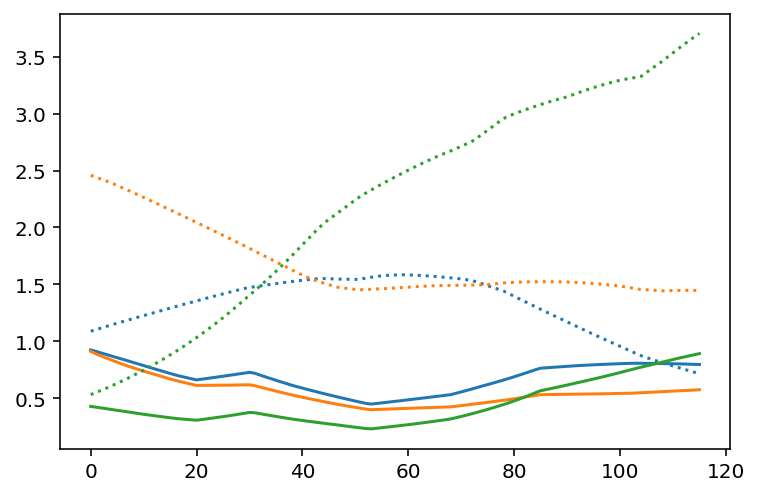

In [34]:
for i in range(3):
    plt.plot(
        data["gene_patterns_raw"].numpy()[0,i,:], color=palette[i]
    )
    plt.plot(
        data["gene_patterns_raw"].numpy()[1,i,:], ls=":", color=palette[i]
    )
effective_scales[:,:3]
    

In [13]:
beta = torch.softmax(samples["beta"]["values"], dim=-1).mean(dim=0).squeeze()
diff_betas = (beta[1] - beta[0]).detach().numpy()

disruption_scores = np.linalg.norm(diff_betas, axis=1)
wald_stat = np.einsum("gk, kl, gl -> g", diff_betas, np.linalg.inv(np.cov(diff_betas, rowvar=False)), diff_betas)


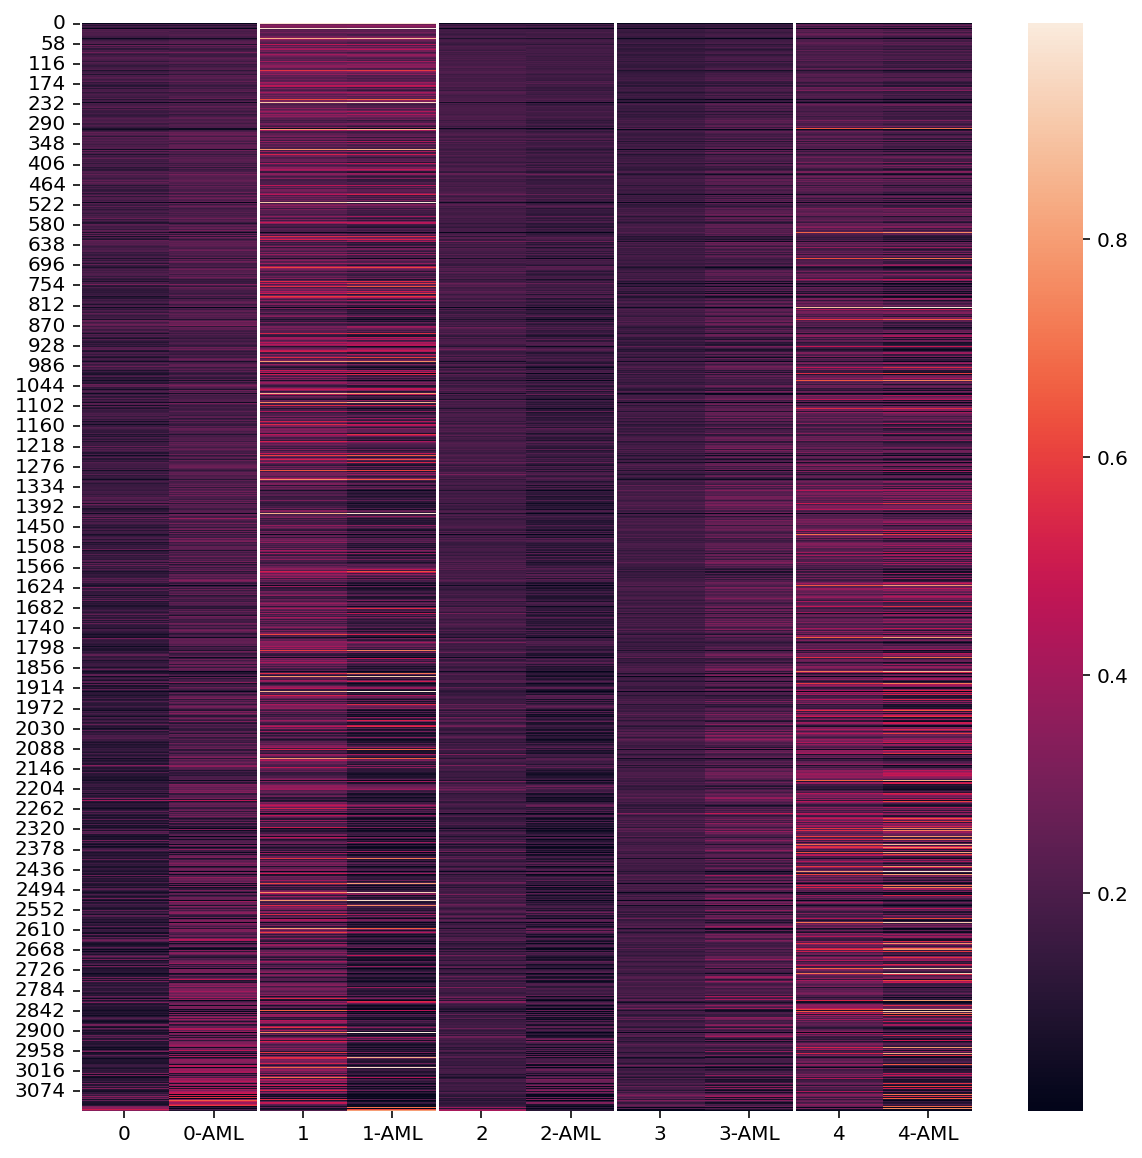

In [17]:
plt.figure(figsize=[10, 10])
cc = sns.heatmap(
    beta
    .squeeze()
    .transpose(0, 1)
    .transpose(1, 2)
    .reshape(3130, -1)
    .numpy()[np.argsort(disruption_scores)],
)
labels = []
for i in range(trajectory_model.K):
    cc.axvline(2 * i, c="white")
    labels.extend([f"{i}", f"{i}-AML"])
cc.set_xticklabels(labels);

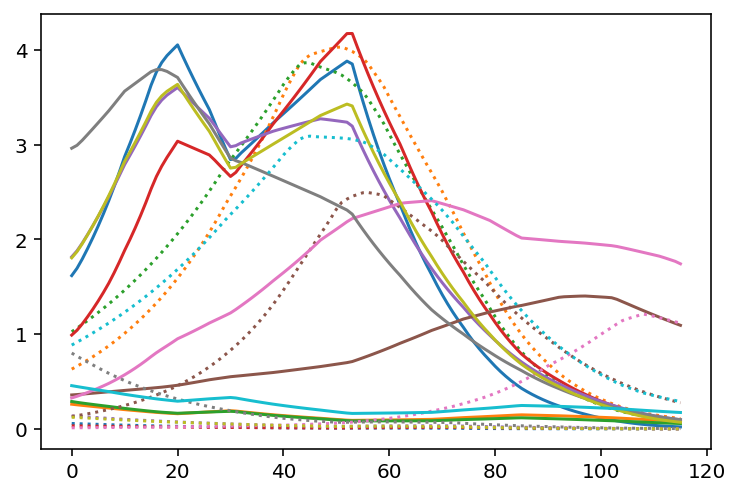

In [18]:
m = 10
palette = sns.color_palette(n_colors=m)
for i in range(m):
    plt.plot(
        gene_patterns.numpy()[0,np.argsort(disruption_scores)[::-1][i],:].T, color=palette[i]
    )
    plt.plot(
        gene_patterns.numpy()[1,np.argsort(disruption_scores)[::-1][i],:].T, color=palette[i], ls=":"
    )